<a href="https://colab.research.google.com/github/kangnurrohman/belajar-recurrent-neural-network/blob/main/materi/Part%205%20-%20GRU%20with%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install jcopdl luwiji

In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/data/data 4.zip", 'r')
zip_ref.extractall("data")
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [5]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Import Data

In [6]:
df = pd.read_csv("/content/data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


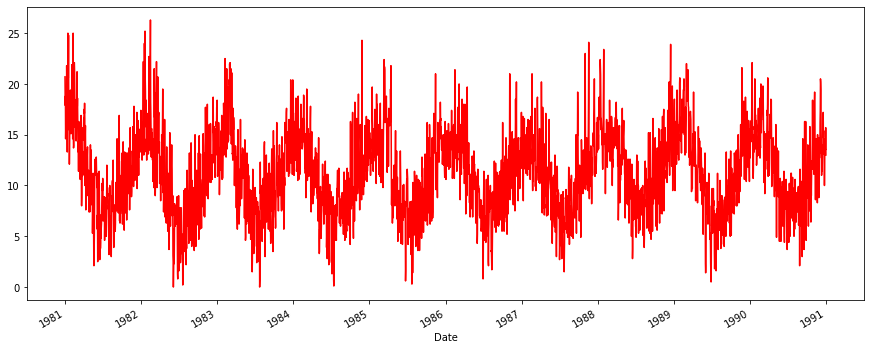

In [7]:
df.Temp.plot(figsize=(15, 6), color='red')

## Dataset Spliting

In [8]:
ts_train, ts_test = train_test_split(df, shuffle=False)
ts_train.shape, ts_test.shape

((2737, 1), (913, 1))

## Dataset & Dataloader

In [9]:
from jcopdl.utils import TimeSeriesDataset
from torch.utils.data import DataLoader

In [11]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
train_loader = DataLoader(train_set, batch_size=bs, num_workers=2)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
test_loader = DataLoader(test_set, batch_size=bs, num_workers=2)

(N, S, F): (195, 14, 1)
Note: last 6 data excluded

(N, S, F): (65, 14, 1)
Note: last 2 data excluded



## Arsitektur & Config

In [12]:
class GRU(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.gru = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x, hidden):
    x, hidden = self.gru(x, hidden)
    x = self.fc(x)
    return x, hidden

In [13]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size":64,
    "num_layers": 3,
    "dropout":0
})

## Training Preparation -> MCOC

In [14]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='/content/data/model/gru')

## Training

In [15]:
from tqdm import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  cost = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output, hidden = model(feature, None)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    cost += loss.item() * feature.shape[0]
  cost = cost / len(dataset)
  return cost

Test: 100%|██████████| 3/3 [00:00<00:00, 33.36it/s]



Epoch     1
Train_cost  = 132.0229 | Test_cost  = 117.7096 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.55it/s]



Epoch     2
Train_cost  = 103.3932 | Test_cost  = 88.9756 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.18it/s]



Epoch     3
Train_cost  = 78.2868 | Test_cost  = 70.0239 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.41it/s]



Epoch     4
Train_cost  = 63.1348 | Test_cost  = 58.9523 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.00it/s]



Epoch     5
Train_cost  = 53.8118 | Test_cost  = 51.0885 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.99it/s]



Epoch     6
Train_cost  = 46.8580 | Test_cost  = 44.7706 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.52it/s]



Epoch     7
Train_cost  = 41.1984 | Test_cost  = 39.5136 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.88it/s]



Epoch     8
Train_cost  = 36.4910 | Test_cost  = 35.1161 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.76it/s]



Epoch     9
Train_cost  = 32.5747 | Test_cost  = 31.4549 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.19it/s]



Epoch    10
Train_cost  = 29.3395 | Test_cost  = 28.4303 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.46it/s]



Epoch    11
Train_cost  = 26.6912 | Test_cost  = 25.9515 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.69it/s]



Epoch    12
Train_cost  = 24.5426 | Test_cost  = 23.9348 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.35it/s]



Epoch    13
Train_cost  = 22.8138 | Test_cost  = 22.3046 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.51it/s]



Epoch    14
Train_cost  = 21.4334 | Test_cost  = 20.9945 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.26it/s]



Epoch    15
Train_cost  = 20.3389 | Test_cost  = 19.9473 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.96it/s]



Epoch    16
Train_cost  = 19.4771 | Test_cost  = 19.1144 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.84it/s]



Epoch    17
Train_cost  = 18.8030 | Test_cost  = 18.4551 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.69it/s]



Epoch    18
Train_cost  = 18.2789 | Test_cost  = 17.9352 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.68it/s]



Epoch    19
Train_cost  = 17.8739 | Test_cost  = 17.5268 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.20it/s]



Epoch    20
Train_cost  = 17.5626 | Test_cost  = 17.2067 | 


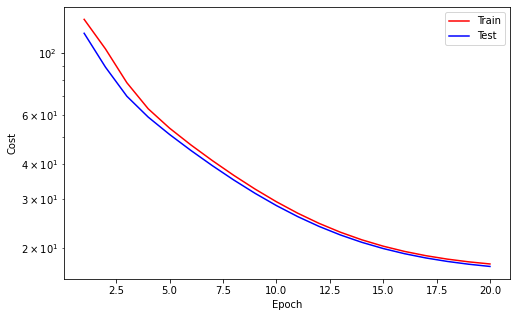

Test: 100%|██████████| 3/3 [00:00<00:00, 41.00it/s]



Epoch    21
Train_cost  = 17.3243 | Test_cost  = 16.9564 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.85it/s]



Epoch    22
Train_cost  = 17.1426 | Test_cost  = 16.7609 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.13it/s]



Epoch    23
Train_cost  = 17.0043 | Test_cost  = 16.6081 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.23it/s]



Epoch    24
Train_cost  = 16.8991 | Test_cost  = 16.4886 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.28it/s]



Epoch    25
Train_cost  = 16.8191 | Test_cost  = 16.3950 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.70it/s]



Epoch    26
Train_cost  = 16.7580 | Test_cost  = 16.3216 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.38it/s]



Epoch    27
Train_cost  = 16.7113 | Test_cost  = 16.2637 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.14it/s]



Epoch    28
Train_cost  = 16.6753 | Test_cost  = 16.2179 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.14it/s]



Epoch    29
Train_cost  = 16.6473 | Test_cost  = 16.1816 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.40it/s]



Epoch    30
Train_cost  = 16.6254 | Test_cost  = 16.1526 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.07it/s]



Epoch    31
Train_cost  = 16.6081 | Test_cost  = 16.1294 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.20it/s]



Epoch    32
Train_cost  = 16.5942 | Test_cost  = 16.1106 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.73it/s]



Epoch    33
Train_cost  = 16.5829 | Test_cost  = 16.0954 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.22it/s]



Epoch    34
Train_cost  = 16.5736 | Test_cost  = 16.0830 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.66it/s]



Epoch    35
Train_cost  = 16.5658 | Test_cost  = 16.0727 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.41it/s]



Epoch    36
Train_cost  = 16.5591 | Test_cost  = 16.0641 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.27it/s]



Epoch    37
Train_cost  = 16.5534 | Test_cost  = 16.0567 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.59it/s]



Epoch    38
Train_cost  = 16.5483 | Test_cost  = 16.0505 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.37it/s]



Epoch    39
Train_cost  = 16.5436 | Test_cost  = 16.0450 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.21it/s]



Epoch    40
Train_cost  = 16.5394 | Test_cost  = 16.0401 | 


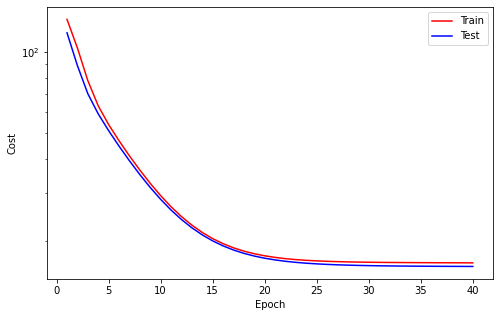

Test: 100%|██████████| 3/3 [00:00<00:00, 38.17it/s]



Epoch    41
Train_cost  = 16.5355 | Test_cost  = 16.0356 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.31it/s]



Epoch    42
Train_cost  = 16.5317 | Test_cost  = 16.0315 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 44.56it/s]



Epoch    43
Train_cost  = 16.5281 | Test_cost  = 16.0276 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.18it/s]



Epoch    44
Train_cost  = 16.5246 | Test_cost  = 16.0239 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.48it/s]



Epoch    45
Train_cost  = 16.5211 | Test_cost  = 16.0203 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 43.11it/s]



Epoch    46
Train_cost  = 16.5177 | Test_cost  = 16.0168 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.06it/s]



Epoch    47
Train_cost  = 16.5143 | Test_cost  = 16.0133 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.94it/s]



Epoch    48
Train_cost  = 16.5108 | Test_cost  = 16.0099 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.23it/s]



Epoch    49
Train_cost  = 16.5074 | Test_cost  = 16.0064 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.55it/s]



Epoch    50
Train_cost  = 16.5039 | Test_cost  = 16.0030 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.22it/s]



Epoch    51
Train_cost  = 16.5003 | Test_cost  = 15.9995 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 42.71it/s]



Epoch    52
Train_cost  = 16.4967 | Test_cost  = 15.9960 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.30it/s]



Epoch    53
Train_cost  = 16.4931 | Test_cost  = 15.9925 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.24it/s]



Epoch    54
Train_cost  = 16.4893 | Test_cost  = 15.9889 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.12it/s]



Epoch    55
Train_cost  = 16.4855 | Test_cost  = 15.9854 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.41it/s]



Epoch    56
Train_cost  = 16.4816 | Test_cost  = 15.9817 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.33it/s]



Epoch    57
Train_cost  = 16.4776 | Test_cost  = 15.9781 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.27it/s]



Epoch    58
Train_cost  = 16.4735 | Test_cost  = 15.9744 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 41.16it/s]



Epoch    59
Train_cost  = 16.4693 | Test_cost  = 15.9707 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.34it/s]



Epoch    60
Train_cost  = 16.4650 | Test_cost  = 15.9670 | 


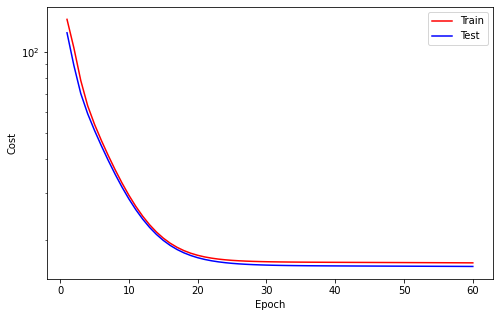

Test: 100%|██████████| 3/3 [00:00<00:00, 39.03it/s]



Epoch    61
Train_cost  = 16.4605 | Test_cost  = 15.9632 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.21it/s]



Epoch    62
Train_cost  = 16.4558 | Test_cost  = 15.9594 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 13.34it/s]



Epoch    63
Train_cost  = 16.4510 | Test_cost  = 15.9557 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.65it/s]



Epoch    64
Train_cost  = 16.4459 | Test_cost  = 15.9518 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 10.51it/s]



Epoch    65
Train_cost  = 16.4406 | Test_cost  = 15.9480 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.02it/s]



Epoch    66
Train_cost  = 16.4350 | Test_cost  = 15.9442 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.49it/s]



Epoch    67
Train_cost  = 16.4290 | Test_cost  = 15.9404 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.39it/s]



Epoch    68
Train_cost  = 16.4226 | Test_cost  = 15.9365 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.54it/s]



Epoch    69
Train_cost  = 16.4155 | Test_cost  = 15.9326 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.73it/s]



Epoch    70
Train_cost  = 16.4077 | Test_cost  = 15.9286 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.85it/s]



Epoch    71
Train_cost  = 16.3988 | Test_cost  = 15.9245 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 40.69it/s]



Epoch    72
Train_cost  = 16.3883 | Test_cost  = 15.9200 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.69it/s]



Epoch    73
Train_cost  = 16.3754 | Test_cost  = 15.9149 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.69it/s]



Epoch    74
Train_cost  = 16.3586 | Test_cost  = 15.9084 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.56it/s]



Epoch    75
Train_cost  = 16.3347 | Test_cost  = 15.8984 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.92it/s]



Epoch    76
Train_cost  = 16.2961 | Test_cost  = 15.8781 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.72it/s]



Epoch    77
Train_cost  = 16.2175 | Test_cost  = 15.8114 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.49it/s]



Epoch    78
Train_cost  = 15.9731 | Test_cost  = 15.4211 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.88it/s]



Epoch    79
Train_cost  = 14.9888 | Test_cost  = 14.1786 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.73it/s]



Epoch    80
Train_cost  = 13.6513 | Test_cost  = 13.1077 | 


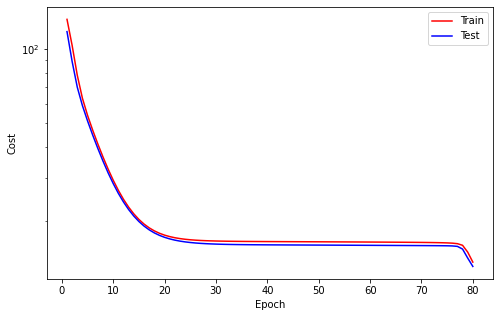

Test: 100%|██████████| 3/3 [00:00<00:00, 38.02it/s]



Epoch    81
Train_cost  = 12.6624 | Test_cost  = 12.3089 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.20it/s]



Epoch    82
Train_cost  = 11.8067 | Test_cost  = 11.5557 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.56it/s]



Epoch    83
Train_cost  = 11.0904 | Test_cost  = 10.8870 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.28it/s]



Epoch    84
Train_cost  = 10.5052 | Test_cost  = 10.3067 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.51it/s]



Epoch    85
Train_cost  = 9.9806 | Test_cost  = 9.7731 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.95it/s]



Epoch    86
Train_cost  = 9.5210 | Test_cost  = 9.3094 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.86it/s]



Epoch    87
Train_cost  = 9.1312 | Test_cost  = 8.9266 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.80it/s]



Epoch    88
Train_cost  = 8.8131 | Test_cost  = 8.6122 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.80it/s]



Epoch    89
Train_cost  = 8.5547 | Test_cost  = 8.3503 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.15it/s]



Epoch    90
Train_cost  = 8.3322 | Test_cost  = 8.1244 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.21it/s]



Epoch    91
Train_cost  = 8.1343 | Test_cost  = 7.9278 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.65it/s]



Epoch    92
Train_cost  = 7.9586 | Test_cost  = 7.7581 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.74it/s]



Epoch    93
Train_cost  = 7.8052 | Test_cost  = 7.6088 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 24.65it/s]



Epoch    94
Train_cost  = 7.6756 | Test_cost  = 7.4746 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 19.68it/s]



Epoch    95
Train_cost  = 7.5651 | Test_cost  = 7.3546 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.17it/s]



Epoch    96
Train_cost  = 7.4659 | Test_cost  = 7.2472 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.12it/s]



Epoch    97
Train_cost  = 7.3743 | Test_cost  = 7.1498 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.15it/s]



Epoch    98
Train_cost  = 7.2899 | Test_cost  = 7.0611 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.51it/s]



Epoch    99
Train_cost  = 7.2127 | Test_cost  = 6.9800 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.70it/s]



Epoch   100
Train_cost  = 7.1427 | Test_cost  = 6.9057 | 


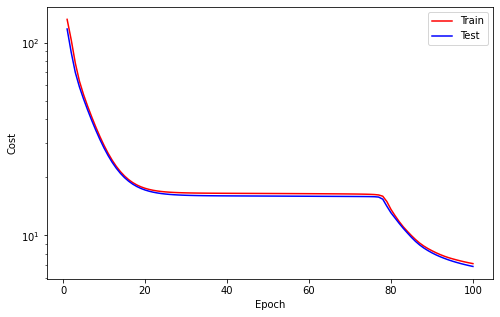

Test: 100%|██████████| 3/3 [00:00<00:00, 36.73it/s]



Epoch   101
Train_cost  = 7.0791 | Test_cost  = 6.8375 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.81it/s]



Epoch   102
Train_cost  = 7.0211 | Test_cost  = 6.7747 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.24it/s]



Epoch   103
Train_cost  = 6.9683 | Test_cost  = 6.7168 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 39.25it/s]



Epoch   104
Train_cost  = 6.9201 | Test_cost  = 6.6634 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.82it/s]



Epoch   105
Train_cost  = 6.8761 | Test_cost  = 6.6140 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.87it/s]



Epoch   106
Train_cost  = 6.8358 | Test_cost  = 6.5683 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.95it/s]



Epoch   107
Train_cost  = 6.7988 | Test_cost  = 6.5259 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.06it/s]



Epoch   108
Train_cost  = 6.7646 | Test_cost  = 6.4866 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.93it/s]



Epoch   109
Train_cost  = 6.7331 | Test_cost  = 6.4499 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.34it/s]



Epoch   110
Train_cost  = 6.7039 | Test_cost  = 6.4155 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.49it/s]



Epoch   111
Train_cost  = 6.6768 | Test_cost  = 6.3833 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.28it/s]



Epoch   112
Train_cost  = 6.6515 | Test_cost  = 6.3529 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.41it/s]



Epoch   113
Train_cost  = 6.6278 | Test_cost  = 6.3243 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.87it/s]



Epoch   114
Train_cost  = 6.6056 | Test_cost  = 6.2972 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.27it/s]



Epoch   115
Train_cost  = 6.5845 | Test_cost  = 6.2716 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.35it/s]



Epoch   116
Train_cost  = 6.5645 | Test_cost  = 6.2472 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.74it/s]



Epoch   117
Train_cost  = 6.5453 | Test_cost  = 6.2240 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.33it/s]



Epoch   118
Train_cost  = 6.5267 | Test_cost  = 6.2015 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.99it/s]



Epoch   119
Train_cost  = 6.5085 | Test_cost  = 6.1792 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.76it/s]



Epoch   120
Train_cost  = 6.4908 | Test_cost  = 6.1567 | 


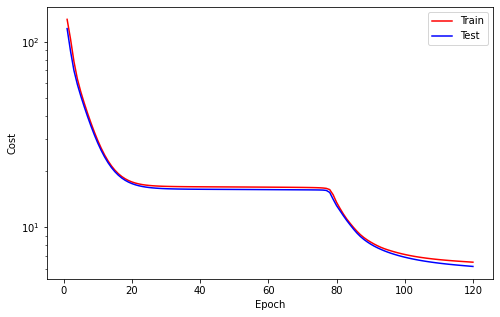

Test: 100%|██████████| 3/3 [00:00<00:00, 35.91it/s]



Epoch   121
Train_cost  = 6.4737 | Test_cost  = 6.1341 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.32it/s]



Epoch   122
Train_cost  = 6.4574 | Test_cost  = 6.1125 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.06it/s]



Epoch   123
Train_cost  = 6.4421 | Test_cost  = 6.0925 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.58it/s]



Epoch   124
Train_cost  = 6.4277 | Test_cost  = 6.0741 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.39it/s]



Epoch   125
Train_cost  = 6.4140 | Test_cost  = 6.0566 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.26it/s]



Epoch   126
Train_cost  = 6.4006 | Test_cost  = 6.0398 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.54it/s]



Epoch   127
Train_cost  = 6.3877 | Test_cost  = 6.0238 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.23it/s]



Epoch   128
Train_cost  = 6.3752 | Test_cost  = 6.0083 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.74it/s]



Epoch   129
Train_cost  = 6.3633 | Test_cost  = 5.9934 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.92it/s]



Epoch   130
Train_cost  = 6.3520 | Test_cost  = 5.9792 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.75it/s]



Epoch   131
Train_cost  = 6.3412 | Test_cost  = 5.9656 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.72it/s]



Epoch   132
Train_cost  = 6.3307 | Test_cost  = 5.9524 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.36it/s]



Epoch   133
Train_cost  = 6.3205 | Test_cost  = 5.9395 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.50it/s]



Epoch   134
Train_cost  = 6.3105 | Test_cost  = 5.9268 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.83it/s]



Epoch   135
Train_cost  = 6.3007 | Test_cost  = 5.9144 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.82it/s]



Epoch   136
Train_cost  = 6.2910 | Test_cost  = 5.9020 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.52it/s]



Epoch   137
Train_cost  = 6.2814 | Test_cost  = 5.8896 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.71it/s]



Epoch   138
Train_cost  = 6.2717 | Test_cost  = 5.8773 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.56it/s]



Epoch   139
Train_cost  = 6.2620 | Test_cost  = 5.8655 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.15it/s]



Epoch   140
Train_cost  = 6.2524 | Test_cost  = 5.8545 | 


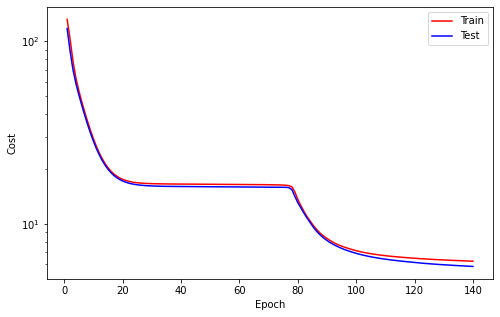

Test: 100%|██████████| 3/3 [00:00<00:00, 33.84it/s]



Epoch   141
Train_cost  = 6.2433 | Test_cost  = 5.8447 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.56it/s]



Epoch   142
Train_cost  = 6.2347 | Test_cost  = 5.8359 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.09it/s]



Epoch   143
Train_cost  = 6.2266 | Test_cost  = 5.8277 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.82it/s]



Epoch   144
Train_cost  = 6.2188 | Test_cost  = 5.8199 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.64it/s]



Epoch   145
Train_cost  = 6.2111 | Test_cost  = 5.8122 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.62it/s]



Epoch   146
Train_cost  = 6.2037 | Test_cost  = 5.8048 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.24it/s]



Epoch   147
Train_cost  = 6.1964 | Test_cost  = 5.7976 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.57it/s]



Epoch   148
Train_cost  = 6.1892 | Test_cost  = 5.7908 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.50it/s]



Epoch   149
Train_cost  = 6.1822 | Test_cost  = 5.7842 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.73it/s]



Epoch   150
Train_cost  = 6.1752 | Test_cost  = 5.7779 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 38.94it/s]



Epoch   151
Train_cost  = 6.1683 | Test_cost  = 5.7719 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.47it/s]



Epoch   152
Train_cost  = 6.1616 | Test_cost  = 5.7662 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.93it/s]



Epoch   153
Train_cost  = 6.1550 | Test_cost  = 5.7607 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.00it/s]



Epoch   154
Train_cost  = 6.1486 | Test_cost  = 5.7554 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.33it/s]



Epoch   155
Train_cost  = 6.1423 | Test_cost  = 5.7503 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.84it/s]



Epoch   156
Train_cost  = 6.1362 | Test_cost  = 5.7453 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.27it/s]



Epoch   157
Train_cost  = 6.1302 | Test_cost  = 5.7405 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.83it/s]



Epoch   158
Train_cost  = 6.1242 | Test_cost  = 5.7358 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.34it/s]



Epoch   159
Train_cost  = 6.1182 | Test_cost  = 5.7315 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.20it/s]



Epoch   160
Train_cost  = 6.1121 | Test_cost  = 5.7275 | 


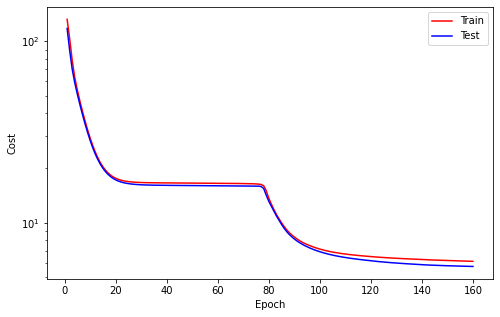

Test: 100%|██████████| 3/3 [00:00<00:00, 35.20it/s]



Epoch   161
Train_cost  = 6.1060 | Test_cost  = 5.7239 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.87it/s]



Epoch   162
Train_cost  = 6.0999 | Test_cost  = 5.7205 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.14it/s]



Epoch   163
Train_cost  = 6.0941 | Test_cost  = 5.7171 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.05it/s]



Epoch   164
Train_cost  = 6.0883 | Test_cost  = 5.7137 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.63it/s]



Epoch   165
Train_cost  = 6.0827 | Test_cost  = 5.7103 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.74it/s]



Epoch   166
Train_cost  = 6.0772 | Test_cost  = 5.7069 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.93it/s]



Epoch   167
Train_cost  = 6.0717 | Test_cost  = 5.7035 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.54it/s]



Epoch   168
Train_cost  = 6.0662 | Test_cost  = 5.7002 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.61it/s]



Epoch   169
Train_cost  = 6.0608 | Test_cost  = 5.6970 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 28.13it/s]



Epoch   170
Train_cost  = 6.0553 | Test_cost  = 5.6938 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.47it/s]



Epoch   171
Train_cost  = 6.0499 | Test_cost  = 5.6907 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.25it/s]



Epoch   172
Train_cost  = 6.0446 | Test_cost  = 5.6876 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.73it/s]



Epoch   173
Train_cost  = 6.0393 | Test_cost  = 5.6845 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.17it/s]



Epoch   174
Train_cost  = 6.0340 | Test_cost  = 5.6815 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.22it/s]



Epoch   175
Train_cost  = 6.0287 | Test_cost  = 5.6786 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.22it/s]



Epoch   176
Train_cost  = 6.0234 | Test_cost  = 5.6758 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 37.47it/s]



Epoch   177
Train_cost  = 6.0181 | Test_cost  = 5.6730 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.86it/s]



Epoch   178
Train_cost  = 6.0128 | Test_cost  = 5.6703 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 31.06it/s]



Epoch   179
Train_cost  = 6.0075 | Test_cost  = 5.6677 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.04it/s]



Epoch   180
Train_cost  = 6.0022 | Test_cost  = 5.6652 | 


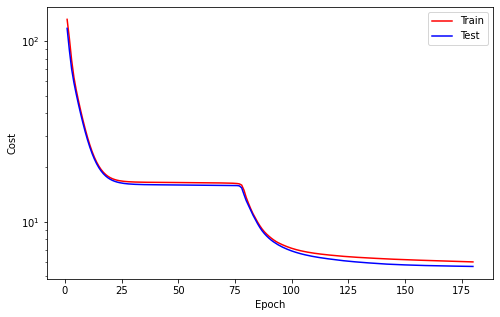

Test: 100%|██████████| 3/3 [00:00<00:00, 31.95it/s]



Epoch   181
Train_cost  = 5.9969 | Test_cost  = 5.6628 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.31it/s]



Epoch   182
Train_cost  = 5.9915 | Test_cost  = 5.6605 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.82it/s]



Epoch   183
Train_cost  = 5.9862 | Test_cost  = 5.6584 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.59it/s]



Epoch   184
Train_cost  = 5.9808 | Test_cost  = 5.6564 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.87it/s]



Epoch   185
Train_cost  = 5.9753 | Test_cost  = 5.6545 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 34.13it/s]



Epoch   186
Train_cost  = 5.9698 | Test_cost  = 5.6527 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.40it/s]



Epoch   187
Train_cost  = 5.9643 | Test_cost  = 5.6511 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.09it/s]



Epoch   188
Train_cost  = 5.9587 | Test_cost  = 5.6496 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.99it/s]



Epoch   189
Train_cost  = 5.9530 | Test_cost  = 5.6483 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 32.79it/s]



Epoch   190
Train_cost  = 5.9473 | Test_cost  = 5.6471 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.53it/s]



Epoch   191
Train_cost  = 5.9416 | Test_cost  = 5.6461 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 35.60it/s]



Epoch   192
Train_cost  = 5.9357 | Test_cost  = 5.6452 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.98it/s]



Epoch   193
Train_cost  = 5.9298 | Test_cost  = 5.6445 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 33.28it/s]



Epoch   194
Train_cost  = 5.9239 | Test_cost  = 5.6440 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 29.18it/s]



Epoch   195
Train_cost  = 5.9179 | Test_cost  = 5.6437 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 36.88it/s]



Epoch   196
Train_cost  = 5.9118 | Test_cost  = 5.6436 | 


Test: 100%|██████████| 3/3 [00:00<00:00, 30.27it/s]



Epoch   197
Train_cost  = 5.9056 | Test_cost  = 5.6437 | 
==> EarlyStop patience =  1 | Best test_cost: 5.6436


Test: 100%|██████████| 3/3 [00:00<00:00, 33.25it/s]



Epoch   198
Train_cost  = 5.8994 | Test_cost  = 5.6440 | 
==> EarlyStop patience =  2 | Best test_cost: 5.6436


Test: 100%|██████████| 3/3 [00:00<00:00, 32.00it/s]



Epoch   199
Train_cost  = 5.8931 | Test_cost  = 5.6444 | 
==> EarlyStop patience =  3 | Best test_cost: 5.6436


Test: 100%|██████████| 3/3 [00:00<00:00, 31.31it/s]



Epoch   200
Train_cost  = 5.8867 | Test_cost  = 5.6451 | 


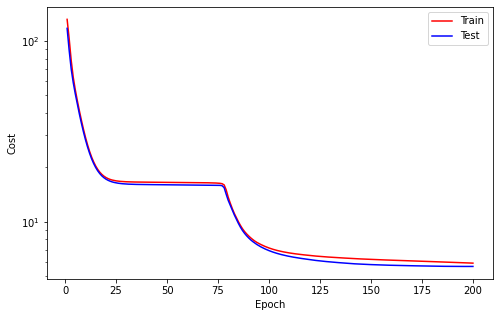

==> EarlyStop patience =  4 | Best test_cost: 5.6436


Test: 100%|██████████| 3/3 [00:00<00:00, 33.81it/s]



Epoch   201
Train_cost  = 5.8803 | Test_cost  = 5.6460 | 
==> EarlyStop patience =  5 | Best test_cost: 5.6436
==> Execute Early Stopping at epoch: 201 | Best test_cost: 5.6436
==> Best model is saved at /content/data/model/gru


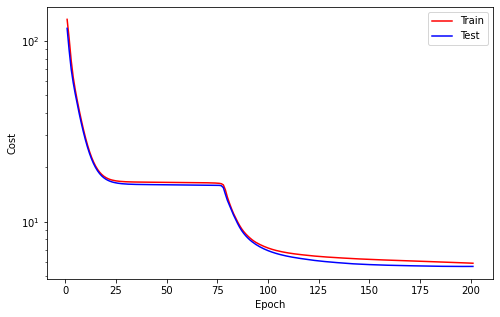

In [16]:
while True:
  train_cost = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost= loop_fn("test", test_set, test_loader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime_plotting
  callback.cost_runtime_plotting()

  #Early stopping
  if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [17]:
# utils
def data4pred(model, dataset, dataloader, device):    
    preds, targets = [], []
    hidden = None
    with torch.no_grad():
        model.eval()
        for inputs, target in dataloader:
            inputs = inputs.to(device)
            
            output, hidden = model(inputs, hidden)
            preds += output.flatten().tolist()
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks, targets, 'b-', label="data")
    plt.plot(dataset.target_ticks, preds, 'r-', label="pred")
    plt.legend()    
    
def pred4pred(model, dataset, dataloader, device, n_prior=500, n_forecast=200):
    preds, targets = [], []
    hidden = None    
    end = n_prior + n_forecast    
    with torch.no_grad():
        model.eval()       
        for idx, (inputs, target) in enumerate(dataloader):
            if idx == end:
                break
            elif idx > n_prior:
                inputs[0, 0, 0] = preds[-1]
                
            inputs = inputs.to(device)
            output, hidden = model(inputs, hidden)
            
            if idx > n_prior:
                preds.append(output.flatten().tolist()[-1])
            else:
                preds += output.flatten().tolist()   
            targets += target.flatten().tolist()

    plt.plot(dataset.target_ticks[:n_prior], targets[:n_prior], 'b-', label="history_data")
    plt.plot(dataset.target_ticks[n_prior:end], targets[n_prior:], 'b-', label="unseen_data", alpha=0.3)
    plt.plot(dataset.target_ticks[:end], preds, 'r-', label="prediction")
    plt.axvline(dataset.target_ticks[n_prior], color='k', linestyle="--", linewidth=1)
    plt.legend()   

In [18]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2736, 1, 1)
Note: last 0 data excluded

(N, S, F): (912, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

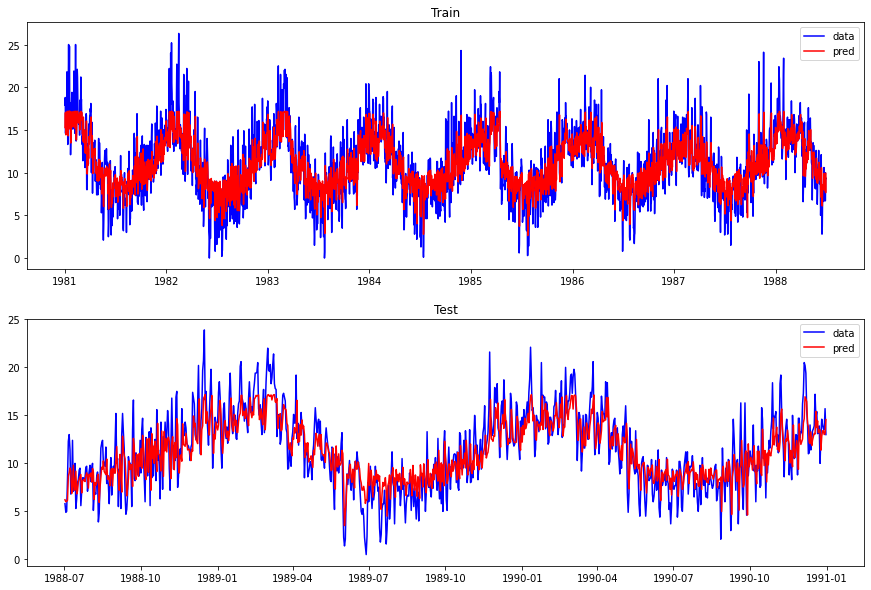

In [19]:
# Data 4 Pred
plt.figure(figsize=(15, 10))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

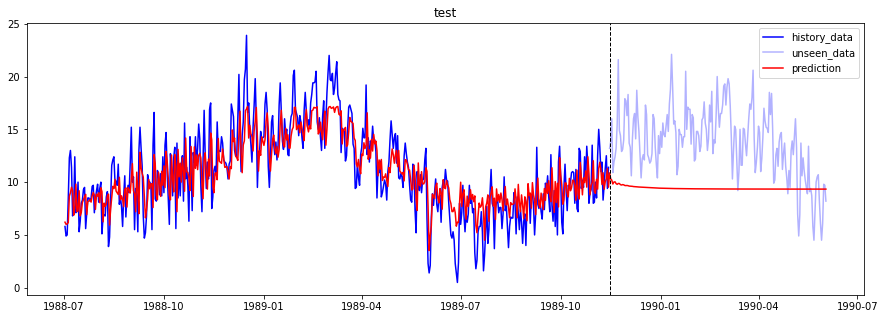

In [20]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")